### This notebook generates the SD-CAPE relationships for MCSs in the idealized RCE simulations. First import libraries and constants.

In [1]:
import numpy as np
from scipy import stats
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm
from zero_buoyancy_plume import zero_buoyancy_plume_alt, tune_entrainment

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# blue-to-red colormap
BR_color_cycle = ["navy", "blue", "lightskyblue", "tomato", "red", "darkred"]

In [2]:
# parameters for this file
nbin = 40
sdupper = 4
sdupper2 = 2.75 # upper bound in SD for ZBP behavior
pc2 = 99
threshold = 20

### Loading RCE data and initializing lists

In [3]:
# note that the files used here are different from the files used elsewhere.
# we select the 99th percentile in SD and CAPE within the MCS rather than values collocated with precipitation.
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/all-var-percentile/'
ssts = np.arange( 290, 315, 5 )
mean_RCE, p99_RCE, rad = read_RCE_files( path )

sd_bins_list = [ [] for i in np.arange( len(mean_RCE) ) ]
capemean_list = [ [] for i in np.arange( len(mean_RCE) ) ]
cape_error_list = [ [] for i in np.arange( len(mean_RCE) ) ]
cape99_list = [ [] for i in np.arange( len(p99_RCE) ) ]

### Scaling of CAPE and saturation deficit across SSTs

In [4]:
cape_cc = np.empty( (3, len(mean_RCE)) )
sd_cc = np.empty( (2, len(mean_RCE)) )
for iterator, array in zip( np.arange(len(p99_RCE)), mean_RCE ):
    sd_RCE = array['SD'].to_numpy()
    capemean_RCE = array['CAPE'].to_numpy()
    #precip_RCE = array['p_rate'].to_numpy()
    #i = np.argwhere( precip_RCE >= np.percentile(precip_RCE,75) )

    sd_bins, capemean_vals, _, cape99_vals, _, cape_error, _, _ = \
        bin_stat_function( nbin, 0, np.nanpercentile(sd_RCE,95), sd_RCE, capemean_RCE, pc2=pc2, threshold=threshold )
    #print( np.nanmin(sd_RCE), np.nanmax(sd_RCE) )
    sd_cc[0,iterator] = np.nanmean( sd_RCE )
    sd_cc[1,iterator] = np.nanmedian( sd_RCE )
    cape_cc[0,iterator] = np.nanmean( capemean_RCE )
    cape_cc[1,iterator] = np.nanmedian( capemean_RCE )
    cape_cc[2,iterator] = np.nanpercentile( capemean_RCE, 99 )
    
    sd_bins_list[iterator] = sd_bins
    capemean_list[iterator] = capemean_vals
    cape99_list[iterator] = cape99_vals
    cape_error_list[iterator] = cape_error

print( 'Scaling [% per K] of SD with SST using mean SD:' )
print( (1 - sd_cc[0,:-1]/sd_cc[0,1:])*100./5. )
print( 'Scaling [% per K] of SD with SST using median SD:' )
print( (1 - sd_cc[1,:-1]/sd_cc[1,1:])*100./5. )
print( 'Scaling [% per K] of CAPE with SST using mean CAPE:' )
print( (1 - cape_cc[0,:-1]/cape_cc[0,1:])*100./5. )
print( 'Scaling [% per K] of CAPE with SST using median CAPE:' )
print( (1 - cape_cc[1,:-1]/cape_cc[1,1:])*100./5. )
print( 'Scaling [% per K] of CAPE with SST using CAPE_99:' )
print( (1 - cape_cc[2,:-1]/cape_cc[2,1:])*100./5. )

Scaling [% per K] of SD with SST using mean SD:
[6.61852078 8.7081662  8.0726835  7.27999978]
Scaling [% per K] of SD with SST using median SD:
[6.23305087 8.18215338 8.17176619 5.91238256]
Scaling [% per K] of CAPE with SST using mean CAPE:
[5.54634054 7.70739176 4.91877991 5.84860708]
Scaling [% per K] of CAPE with SST using median CAPE:
[5.56711906 6.81095073 5.75432664 3.39347718]
Scaling [% per K] of CAPE with SST using CAPE_99:
[ 7.32374713 12.11072218  4.65577283  9.76999555]


### Filter the scaling of CAPE and saturation deficit for different MCS extents

In [5]:
sd_RCE_all = RCE_concat( mean_RCE, 'SD' )
capemean_RCE = RCE_concat( mean_RCE, 'CAPE' )
rad_RCE = np.concatenate( [r for r in rad], axis=0 )

sd_bins_all, capemean_vals_all, _, cape99_vals_all, sd_error_all, cape_error_all, _, _ = \
        bin_stat_function( nbin, 0, sdupper, sd_RCE_all, capemean_RCE, pc2=pc2, threshold=10 )

loo = np.percentile( rad_RCE, 25 )
upp = np.percentile( rad_RCE, 75 )
sd_bins_small, capemean_vals_small, _, cape99_vals_small, _, _, _, _ = \
        bin_stat_function( nbin, 0, sdupper, sd_RCE_all[rad_RCE<=loo], capemean_RCE[rad_RCE<=loo], pc2=pc2, threshold=threshold )
sd_bins_large, capemean_vals_large, _, cape99_vals_large, _, _, _, _ = \
        bin_stat_function( nbin, 0, sdupper, sd_RCE_all[rad_RCE>=upp], capemean_RCE[rad_RCE>=upp], pc2=pc2, threshold=threshold )

In [6]:
# Linear regression between all SDs and CAPE
j = np.argwhere( ~np.isnan( sd_bins_all ) & ( sd_bins_all <= sdupper2) )
out_all = stats.linregress( x=sd_bins_all[j[:,0]], y=capemean_vals_all[j[:,0]] )
print( 'All MCSs - mean CAPE: ' )
print(out_all)

j = np.argwhere( ~np.isnan( sd_bins_small ) & ( sd_bins_all <= sdupper2)  )
out_small = stats.linregress( x=sd_bins_small[j[:,0]], y=capemean_vals_small[j[:,0]] )
print( 'Small MCSs - mean CAPE: ' )
print(out_small)

j = np.argwhere( ~np.isnan( sd_bins_large ) & ( sd_bins_all <= sdupper2) )
out_large = stats.linregress( x=sd_bins_large[j[:,0]], y=capemean_vals_large[j[:,0]] )
print( 'Large MCSs - mean CAPE: ' )
print(out_large)
print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

j = np.argwhere( ~np.isnan( sd_bins_all ) & ( sd_bins_all <= sdupper2)  )
out_all99 = stats.linregress( x=sd_bins_all[j[:,0]], y=cape99_vals_all[j[:,0]] )
print( 'All MCSs - extreme CAPE: ' )
print(out_all99)

j = np.argwhere( ~np.isnan( sd_bins_small ) & ( sd_bins_small <= sdupper2) )
out_small99 = stats.linregress( x=sd_bins_small[j[:,0]], y=cape99_vals_small[j[:,0]] )
print( 'Small MCSs - extreme CAPE: ' )
print(out_small99)

j = np.argwhere( ~np.isnan( sd_bins_large ) & ( sd_bins_large <= sdupper2) )
out_large99 = stats.linregress( x=sd_bins_large[j[:,0]], y=cape99_vals_large[j[:,0]] )
print( 'Large MCSs - extreme CAPE: ' )
print(out_large99)

All MCSs - mean CAPE: 
LinregressResult(slope=522.2545285938344, intercept=558.0722619675873, rvalue=0.9097231949792419, pvalue=2.979759704633737e-10, stderr=49.70296880875058, intercept_stderr=82.52944114655419)
Small MCSs - mean CAPE: 
LinregressResult(slope=712.2033049921193, intercept=478.57505929481647, rvalue=0.9177060548175093, pvalue=1.2159998281726845e-08, stderr=72.66731209011178, intercept_stderr=107.85551612132599)
Large MCSs - mean CAPE: 
LinregressResult(slope=585.729126772206, intercept=346.60862232814407, rvalue=0.9824248456405579, pvalue=4.332106761077638e-13, stderr=27.821813324793087, intercept_stderr=41.281211382479086)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
All MCSs - extreme CAPE: 
LinregressResult(slope=1645.351559708897, intercept=1334.46563863768, rvalue=0.8418974897573359, pvalue=1.3260487126126437e-07, stderr=219.90630702270565, intercept_stderr=365.1440760615338)
Small MCSs - extreme CAPE: 
LinregressResult(slope=2014.870973904522, intercept=1045.7256444617005, r

### Calculate ZBP CAPE values for these data

In [7]:
# read in requisite values for ZBP CAPE calculations
T_RCE_all = RCE_concat( mean_RCE, 'TABS' )
qv_RCE_all = RCE_concat( mean_RCE, 'QV' )
P_RCE_all = RCE_concat( mean_RCE, 'p' )
altitudes = mean_RCE[0]['z'].to_numpy()

# filter values for size 
loo = np.percentile( rad_RCE, 25 )
upp = np.percentile( rad_RCE, 75 )

T_RCE_small = T_RCE_all[ rad_RCE <= loo ]
qv_RCE_small = qv_RCE_all[ rad_RCE <= loo ]
P_RCE_small = P_RCE_all[ rad_RCE <= loo ]
sd_RCE_small = sd_RCE_all[ rad_RCE <= loo ]

T_RCE_large = T_RCE_all[ rad_RCE >= upp ]
qv_RCE_large = qv_RCE_all[ rad_RCE >= upp ]
P_RCE_large = P_RCE_all[ rad_RCE >= upp ]
sd_RCE_large = sd_RCE_all[ rad_RCE >= upp ]

In [8]:
# calculate the zero-buoyancy plume CAPE value for a given collocation, minimize epsilon
epsilon_range = np.logspace( -5, -2, 50 ) 

results = tune_entrainment( epsilon_range, capemean_vals_all, nbin, sdupper, sd_RCE_all, pc2, T_RCE_all, qv_RCE_all, P_RCE_all,
                          altitudes)
min_result = min( results, key=lambda x: x[1] )
print(f"Optimal epsilon - All MCSs (mean): {min_result[0]}")

results = tune_entrainment( epsilon_range, cape99_vals_all, nbin, sdupper, sd_RCE_all, pc2, T_RCE_all, qv_RCE_all, P_RCE_all,
                          altitudes)
min_result = min( results, key=lambda x: x[1] )
print(f"Optimal epsilon - All MCSs (extreme): {min_result[0]}")

Optimal epsilon - All MCSs (mean): 0.00016768329368110083
Optimal epsilon - All MCSs (extreme): 0.0004498432668969444


In [9]:
#del CAPE_zbp
epsilon = min_result[0]
CAPE_zbp = np.empty( T_RCE_all.shape[0] )
for i in np.arange( T_RCE_all.shape[0] ):
    CAPE_zbp[i], _ = zero_buoyancy_plume_alt( T_RCE_all[i], qv_RCE_all[i]*1e-3, P_RCE_all[i]*1e2,
                                             altitudes, epsilon=epsilon )

sd_bins_zbp, _, _, cape99_vals_zbp, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_RCE_all, CAPE_zbp, pc2=pc2, threshold=10 )

In [10]:
# Tuning entrainment for mean CAPE small versus large
results = tune_entrainment( epsilon_range, capemean_vals_small, nbin, sdupper, sd_RCE_small, pc2, T_RCE_small, qv_RCE_small,
                                P_RCE_small, altitudes )
min_result = min( results, key=lambda x: x[1] )
print(f"Optimal epsilon - Small MCSs (mean): {min_result[0]} ")

results = tune_entrainment( epsilon_range, capemean_vals_large, nbin, sdupper, sd_RCE_large, pc2, T_RCE_large, qv_RCE_large,
                                P_RCE_large, altitudes )
min_result = min( results, key=lambda x: x[1] )
print(f"Optimal epsilon - Large MCSs (mean): {min_result[0]}")

# Tuning entrainment for extreme CAPE small versus large
results = tune_entrainment( epsilon_range, cape99_vals_small, nbin, sdupper, sd_RCE_small, pc2, T_RCE_small, qv_RCE_small,
                                P_RCE_small, altitudes )
min_result = min( results, key=lambda x: x[1] )
print(f"Optimal epsilon - Small MCSs (extreme): {min_result[0]} ")

results = tune_entrainment( epsilon_range, cape99_vals_large, nbin, sdupper, sd_RCE_large, pc2, T_RCE_large, qv_RCE_large,
                                P_RCE_large, altitudes )
min_result = min( results, key=lambda x: x[1] )
print(f"Optimal epsilon - Large MCSs (extreme): {min_result[0]}")

Optimal epsilon - Small MCSs (mean): 0.00019306977288832496 
Optimal epsilon - Large MCSs (mean): 0.00014563484775012445
Optimal epsilon - Small MCSs (extreme): 0.0004498432668969444 
Optimal epsilon - Large MCSs (extreme): 0.00029470517025518097


### Plot scalings, regressions, and ZBP output

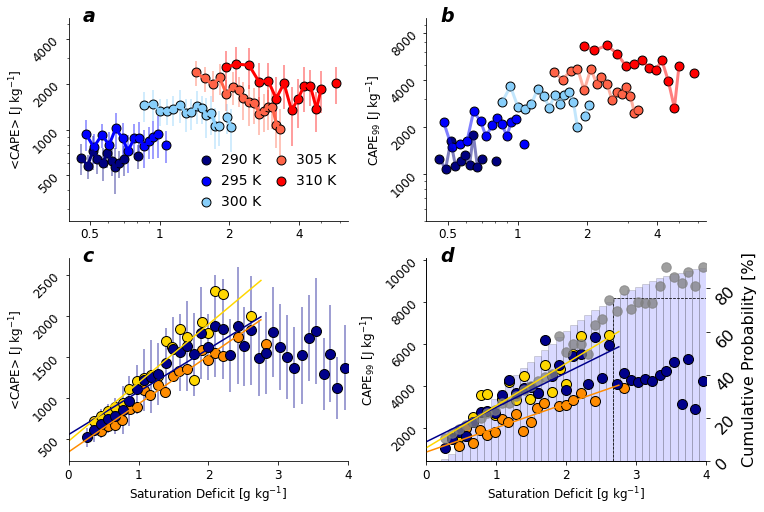

In [11]:
fig, ax = plt.subplots( 2, 2, figsize =(10.5, 7), constrained_layout=True )
sdarray = np.linspace( 0, 2.75, nbin )

ylab = [ r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]', r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]' ]
xlab = [ '', '', r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]' ]
let = [ 'a', 'b', 'c', 'd' ]
font_size = 16
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flatten()): 
    axis.set( ylabel = ylab[i] )
    axis.set( xlabel = xlab[i] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.text( 0.05, 0.98, let[i], transform=axis.transAxes, fontsize=font_size+3, style='italic', weight='bold' )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    if i == 0:
        for j, k, l, m in zip(sd_bins_list, capemean_list, np.arange(len(sd_bins_list)), cape_error_list):
            axis.plot( j, k, color = BR_color_cycle[l], linewidth=3 )
            axis.scatter( j, k, color = BR_color_cycle[l], s=80, edgecolor='black', label=str(ssts[l])+' K' )
            axis.errorbar( j, k, xerr=None, yerr=m/2, color = BR_color_cycle[l], alpha=0.5, ls='none', zorder=-1 )
        axis.legend( frameon=False, ncol=2, fontsize=14, loc='lower right', columnspacing=0.4, handletextpad=0.05 )
        axis.set_ylim([250, 5500])
        axis.set_yscale('log')
        axis.set_xscale('log')
        axis.set_yticks( [500, 1000, 2000, 4000] )
        axis.set_yticklabels( [500, 1000, 2000, 4000] )
        axis.set_xticks( [ 0.5, 1, 2, 4] )
        axis.set_xticklabels( [0.5, 1, 2, 4] )
        
    elif i == 1:
        for j, k, l in zip(sd_bins_list, cape99_list, np.arange(len(sd_bins_list))):
            axis.plot( j, k, color = BR_color_cycle[l], linewidth=3, alpha=0.5 )
            axis.scatter( j, k, color = BR_color_cycle[l], s=80, edgecolor='black', label=str(ssts[l])+' K' )
            
        axis.set_yscale('log')
        axis.set_xscale('log')
        axis.set_ylim([500, 10000])
        axis.set_yticks( [1000, 2000, 4000, 8000] )
        axis.set_yticklabels( [1000, 2000, 4000, 8000] )
        axis.set_xticks( [0.5, 1, 2, 4] )
        axis.set_xticklabels( [0.5, 1, 2, 4] )
    elif i == 2:
        axis.errorbar( sd_bins_all, capemean_vals_all, xerr=sd_error_all/2, yerr=cape_error_all/2, color = 'darkblue',
                      ls='none', zorder=0, alpha=0.5 )
        axis.plot( sdarray, out_all.slope*sdarray+out_all.intercept, color='darkblue', lw=1.5 )
        axis.plot( sdarray, out_small.slope*sdarray+out_small.intercept, color='gold', lw=1.5 )
        axis.plot( sdarray, out_large.slope*sdarray+out_large.intercept, color='darkorange', lw=1.5 )
        axis.scatter( sd_bins_small, capemean_vals_small, color='gold', s=100, edgecolor='black'  )
        axis.scatter( sd_bins_large, capemean_vals_large, color='darkorange', s=100, edgecolor='black'  )
        axis.scatter( sd_bins_all, capemean_vals_all, color='darkblue', s=100, edgecolor='black'  )
        axis.set_xlim([0, sdupper])
    else:
        axis.plot( sdarray, out_all99.slope*sdarray+out_all99.intercept, color='darkblue', lw=1.5 )
        axis.plot( sdarray, out_small99.slope*sdarray+out_small99.intercept, color='gold', lw=1.5 )
        axis.plot( sdarray, out_large99.slope*sdarray+out_large99.intercept, color='darkorange', lw=1.5 )
        axis.scatter( sd_bins_small, cape99_vals_small, color='gold', s=100, edgecolor='black'  )
        axis.scatter( sd_bins_large, cape99_vals_large, color='darkorange', s=100, edgecolor='black'  )
        axis.scatter( sd_bins_all, cape99_vals_all, color='darkblue', s=100, edgecolor='black'  )
        axis.scatter( sd_bins_zbp, cape99_vals_zbp, color='gray', s=90, alpha=0.75 )
        
        wgts = np.ones_like( sd_RCE_all )/float(len(sd_RCE_all))*100.
        axis2 = axis.twinx()
        axis.set_zorder(10)
        axis.patch.set_visible(False)
        axis2.spines['top'].set_visible( False )
        axis2.spines['right'].set_visible( False )
        axis2.set_ylabel( 'Cumulative Probability [%]', fontsize=font_size )
        for t in axis2.get_yticklabels():
            t.set_rotation(45)
        h, edges = np.histogram( sd_RCE_all, bins=np.linspace(0,sdupper,nbin), weights=wgts )
        axis2.hist( sd_RCE_all, bins=np.linspace(0,sdupper,nbin), cumulative=True, alpha=0.15, weights=wgts, color='blue', edgecolor='k' )
        axis.set_xlim([0, sdupper])
        axis2.set_xlim([0, sdupper])
        axis2.plot( [2.6666, sdupper], [75.67, 75.67], lw=0.75, ls='--', color='k' )
        axis2.plot( [2.6666, 2.6666], [0, 75.67], lw=0.75, ls='--', color='k' )
            
#plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/sd-cape-RCE-percentiles.pdf', bbox_inches='tight' )
plt.show()